# PRACTICE \#2: Generative Adversarial Networks (GANs)
## Course: Advanced Computer Vision

## Student

| ID | Name | Class |
| --- | --- | --- |
| 21127240 | Nguyễn Phát Đạt | HP2-K33|

## Instructors

* Ly Quoc Ngoc
* Nguyen Manh Hung

## Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Load data

In [ ]:
BATCH_SIZE = 64

In [ ]:
location_path = "/content/drive/MyDrive/Advanced Computer Vision/data"
# Load the dataset
dataset = torchvision.datasets.MNIST(root=location_path,
                                      transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))]),
                                      download=True)

total_size = len(dataset)
test_size = int(0.01 * total_size)
train_size = total_size - test_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total dataset size: {total_size}')
print(f'Training dataset size: {train_size}')
print(f'Test dataset size: {test_size}')

Total dataset size: 60000
Training dataset size: 59400
Test dataset size: 600


Let's view some samples

In [ ]:
df = pd.DataFrame({"img": pd.Series([img.flatten() for img in train_dataset.dataset.data.numpy()]),
                   "label": train_dataset.dataset.targets.numpy()})

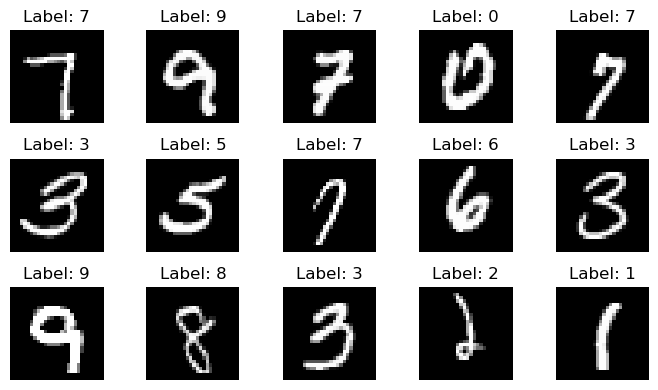

In [ ]:
rows = 3
cols = 5

samples = df.sample(rows * cols)

fig, axes = plt.subplots(rows, cols, figsize=(7, 4), sharex=True, sharey=True)

for i in range(rows):
    for j in range(cols):
        sample = samples.iloc[i * cols + j]
        axes[i, j].imshow(sample['img'].reshape(28, 28), cmap="gray")
        axes[i, j].set_title(f"Label: {sample['label']}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Construct model

### Hyperparameters

In [ ]:
EPOCHS = 25

# Optimizer
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

# Discriminator
D_INPUT_CHANNEL = 1
D_HIDDEN_CHANNELS = [64, 128, 256]
D_OUTPUT_DIM = 1

# Generator
G_INPUT_DIM = 100
G_HIDDEN_CHANNELS = [512, 256, 128, 64]
G_OUTPUT_CHANNEL = D_INPUT_CHANNEL

### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_channels, output_channel):
        super(Generator, self).__init__()

        layers = []
        for i in range(len(hidden_channels)):
            if i == 0:
                # First layer from input_dim to the first hidden_dim
                layers.append(nn.ConvTranspose2d(input_dim, hidden_channels[i],
                                                 kernel_size=4, stride=1, padding=0, bias=False))
            else:
                # Subsequent layers
                layers.append(nn.ConvTranspose2d(hidden_channels[i-1], hidden_channels[i],
                                                 kernel_size=4, stride=2, padding=1, bias=False))

            layers.append(nn.BatchNorm2d(hidden_channels[i]))
            layers.append(nn.ReLU(inplace=True))

        # Output layer
        layers.append(nn.ConvTranspose2d(hidden_channels[-1], output_channel,
                                         kernel_size=1, stride=1, padding=2, bias=False))
        layers.append(nn.Tanh())

        self.main = nn.Sequential(*layers)

    def forward(self, z):
        return self.main(z)

### Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channel, hidden_channels, output_dim):
        super(Discriminator, self).__init__()

        layers = []

        for i in range(len(hidden_channels)):
            if i == 0:
                # First layer from input_channel to the first hidden_dim
                layers.append(nn.Conv2d(input_channel, hidden_channels[i],
                                        kernel_size=4, stride=2, padding=1, bias=False))
            else:
                # Subsequent layers
                layers.append(nn.Conv2d(hidden_channels[i-1], hidden_channels[i],
                                        kernel_size=4, stride=2, padding=1, bias=False))
                # Batchnorm only for hidden layers
                layers.append(nn.BatchNorm2d(hidden_channels[i]))

            layers.append(nn.LeakyReLU(0.2, inplace=True))

        # Output layer
        layers.append(nn.Conv2d(hidden_channels[-1], output_dim,
                                kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.Sigmoid())  # Output a probability

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

### Inittialize

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

D = Discriminator(input_channel=D_INPUT_CHANNEL, hidden_channels=D_HIDDEN_CHANNELS, output_dim=D_OUTPUT_DIM).to(device)

G = Generator(input_dim=G_INPUT_DIM, hidden_channels=G_HIDDEN_CHANNELS, output_channel=G_OUTPUT_CHANNEL).to(device)

Device:  cuda


### Optimizer

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
G_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

### Loss

In [ ]:
def calc_real_loss(D_output, device, label_smoothing=False):
    real_label = torch.ones(D_output.size(0), 1, device=device)
    if label_smoothing:
        real_label = real_label * 0.9
    criterion = nn.BCELoss()
    return criterion(D_output.squeeze(), real_label.squeeze())

def calc_fake_loss(D_output, device):
    fake_label = torch.zeros(D_output.size(0), 1, device=device)
    criterion = nn.BCELoss()
    return criterion(D_output.squeeze(), fake_label.squeeze())

## Train

In [ ]:
training_losses = []
# create a fixed noise to print the generation process later
fixed_noise = torch.randn([BATCH_SIZE, G_INPUT_DIM, 1, 1], device=device)
training_generations = []

n_batches = len(train_dataloader)

for epoch in range(EPOCHS):
    for i, (real_imgs, _) in enumerate(train_dataloader):
        real_imgs = real_imgs.to(device)
        # STEP1: Discriminator optimization
        # Reset gradients
        D_optimizer.zero_grad()

        # 1. real images
        D_real = D(real_imgs)

        d_real_loss = calc_real_loss(D_real, device=device, label_smoothing=True)

        # 2. fake images
        z = torch.randn([real_imgs.size(0), G_INPUT_DIM, 1, 1], device=device)
        fake_images = G(z).detach()
        D_fake = D(fake_images)

        d_fake_loss = calc_fake_loss(D_fake, device=device)
        # add up loss
        lossD = d_real_loss + d_fake_loss
        lossD.backward()
        D_optimizer.step()

        # STEP2: Generator optimization
        # Reset gradients
        G_optimizer.zero_grad()

        z = torch.randn([real_imgs.size(0), G_INPUT_DIM, 1, 1], device=device)
        fake_img = G(z)

        fake_pred = D(fake_img)

        lossG = calc_real_loss(fake_pred, device=device)
        lossG.backward()
        G_optimizer.step()


        if i % 300 == 0 and epoch % 5 == 0: # print d_loss and g_loss
                print(f'[Epoch {epoch+1:3d} / {EPOCHS}] [Batch {i+1:5d} / {n_batches}] [D_loss: {lossD.item():.4f}] [G_loss: {lossG.item():.4f}]')

    training_losses.append((lossD.item(), lossG.item()))

    # generations
    G.eval()
    samples_z = G(fixed_noise)
    training_generations.append(samples_z)
    G.train() # back to train mode


[Epoch   1 / 25] [Batch     1 / 929] [D_loss: 1.3895] [G_loss: 0.9461]
[Epoch   1 / 25] [Batch   301 / 929] [D_loss: 0.3266] [G_loss: 7.7168]
[Epoch   1 / 25] [Batch   601 / 929] [D_loss: 0.3258] [G_loss: 8.5030]
[Epoch   1 / 25] [Batch   901 / 929] [D_loss: 1.0589] [G_loss: 3.2483]
[Epoch   6 / 25] [Batch     1 / 929] [D_loss: 1.1159] [G_loss: 0.9988]
[Epoch   6 / 25] [Batch   301 / 929] [D_loss: 1.3763] [G_loss: 0.8708]
[Epoch   6 / 25] [Batch   601 / 929] [D_loss: 1.0284] [G_loss: 1.1730]
[Epoch   6 / 25] [Batch   901 / 929] [D_loss: 0.9929] [G_loss: 1.5382]
[Epoch  11 / 25] [Batch     1 / 929] [D_loss: 1.0182] [G_loss: 1.3237]
[Epoch  11 / 25] [Batch   301 / 929] [D_loss: 0.9466] [G_loss: 1.5876]
[Epoch  11 / 25] [Batch   601 / 929] [D_loss: 1.0302] [G_loss: 1.4100]
[Epoch  11 / 25] [Batch   901 / 929] [D_loss: 1.1581] [G_loss: 1.0600]
[Epoch  16 / 25] [Batch     1 / 929] [D_loss: 1.0584] [G_loss: 1.1336]
[Epoch  16 / 25] [Batch   301 / 929] [D_loss: 0.9977] [G_loss: 1.7867]
[Epoch

In [ ]:
device = 'cpu' # use gpu only for training

### View training losses

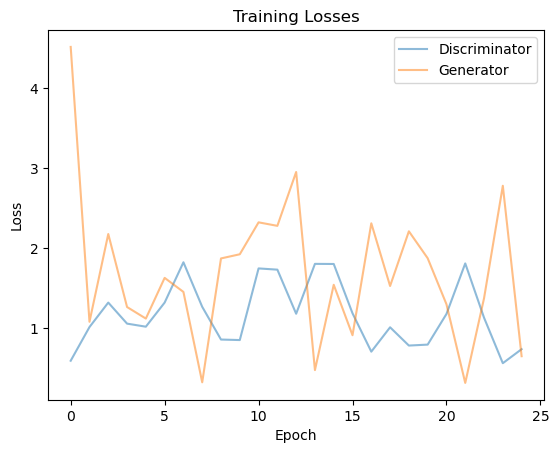

In [ ]:
plt.title("Training Losses")
plt.plot([loss[0] for loss in training_losses], label='Discriminator', alpha=0.5)
plt.plot([loss[1] for loss in training_losses], label='Generator', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

* Overall, it's still similar to GAN, initially experiencing exploding loss values (due to random initialization) and seemingly still fluctuating quite significantly.

* However, it can be seen that the error gap between the two models is much closer, and the Generator doesn't get worse when the Discriminator improves, indicating that both are developing more evenly and stably.

### View training generations

In [ ]:
def plot_generations(samples, title=None, ax_titles=None, color_condition=None, max_cols=8):
    num_images = len(samples)
    num_cols = min(num_images, max_cols)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows

    fig, axes = plt.subplots(figsize=(num_cols, num_rows),
                             nrows=num_rows, ncols=num_cols, sharey=True, sharex=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = samples[i]
            ax.imshow(img.reshape(28, 28), cmap='Greys_r')
            if ax_titles is not None:
                if color_condition is None:
                    ax.set_title(ax_titles[i], fontsize=8)
                else:
                    ax.set_title(ax_titles[i], fontsize=8, color="green" if color_condition[i] else "red")
        ax.axis('off')  # Hide any extra axes

    if title is not None:
        fig.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

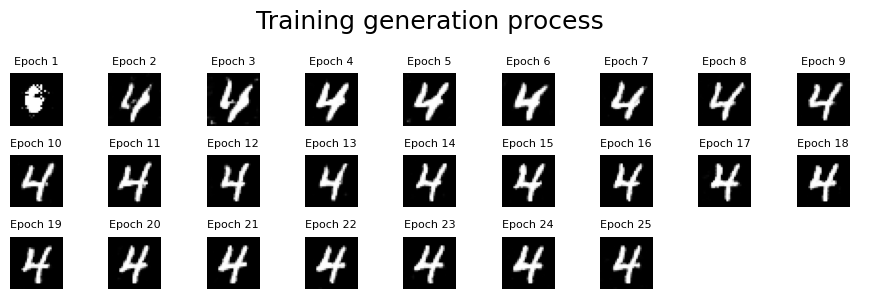

In [ ]:
batch_to_view = 12
step = 1
view_imgs = [imgs[batch_to_view][-1].cpu().detach().numpy() for imgs in training_generations[::step]]
plot_generations(view_imgs, title="Training generation process",
                 ax_titles=[f"Epoch {i * step + 1}" for i in range(len(view_imgs))], max_cols=9)

* Unlike the GAN model, DCGAN seems to eliminate noise quite early (after only about 4 epochs), and the generated images have higher sharpness and are less blurry.

* Additionally, the model also decides the digits class earlier, rather than constantly changing as in GAN.

## Save model

In [ ]:
D_cp_path = "D.pth"
G_cp_path = "G.pth"
torch.save(D.state_dict(), D_cp_path) # discriminator
torch.save(G.state_dict(), G_cp_path) # generator

## Load model

In [ ]:
D2 = Discriminator(input_channel=D_INPUT_CHANNEL, hidden_channels=D_HIDDEN_CHANNELS, output_dim=D_OUTPUT_DIM).to(device)
G2 = Generator(input_dim=G_INPUT_DIM, hidden_channels=G_HIDDEN_CHANNELS, output_channel=G_OUTPUT_CHANNEL).to(device)

D2.load_state_dict(torch.load(D_cp_path))
G2.load_state_dict(torch.load(G_cp_path))


<All keys matched successfully>

## Running inference

### View performance on fake images

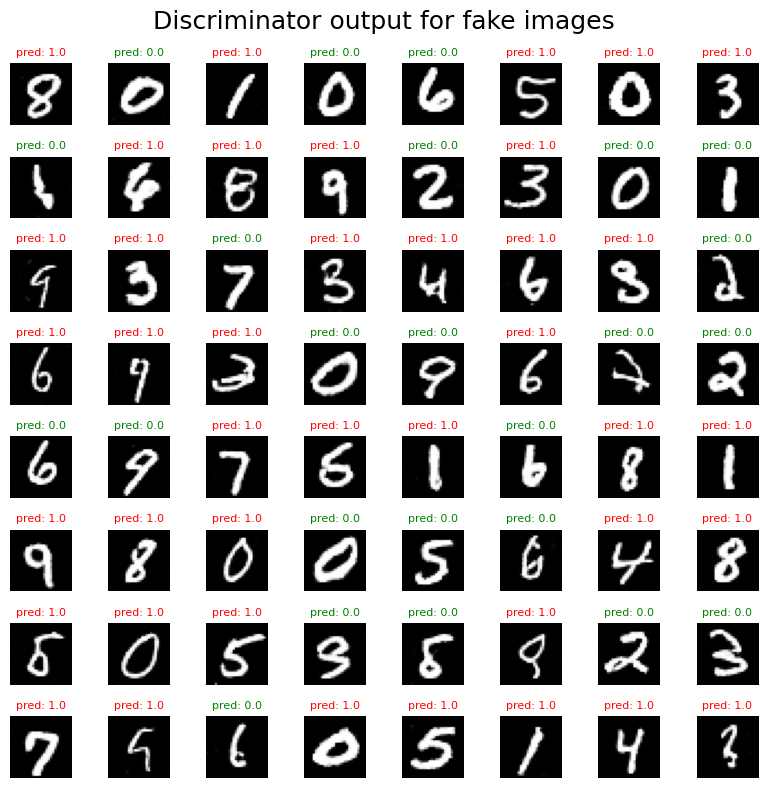

In [ ]:
# generate a batch of gaussian noises randomly
rand_z = torch.randn([BATCH_SIZE, G_INPUT_DIM, 1, 1], device=device)

# eval mode
G2.eval()
D2.eval()

rand_images = G2(rand_z.to(device)) # generated samples

fake_pred = D2(rand_images).detach().numpy().flatten().round()

plot_generations(rand_images.detach().numpy(),
                 title="Discriminator output for fake images",
                 color_condition=fake_pred==0,
                 ax_titles=[f"pred: {d_label}" for d_label in fake_pred])

### View performance on real images

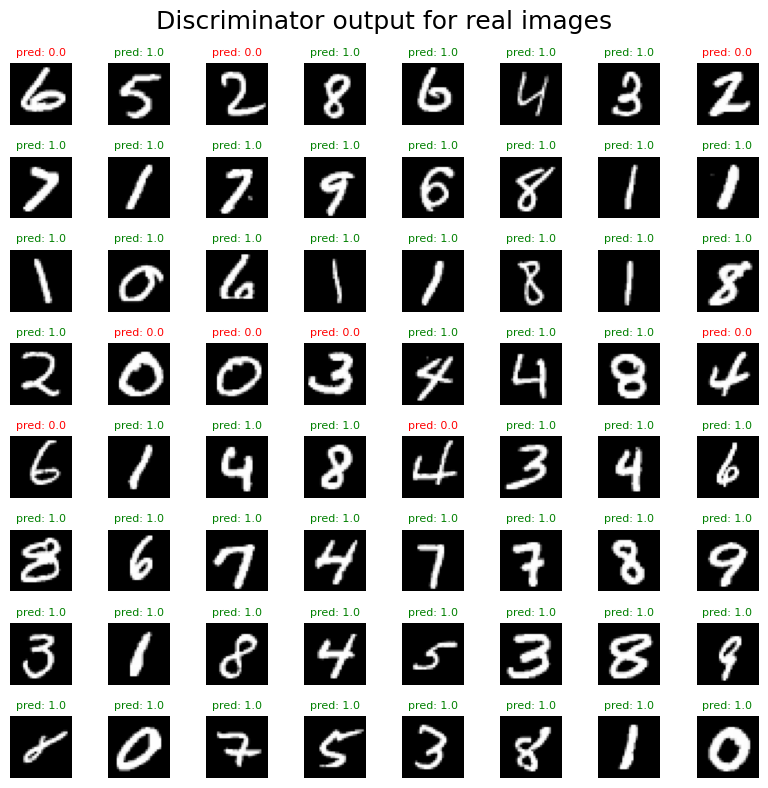

In [ ]:
for i, (real_imgs, _) in enumerate(test_dataloader):
    real_imgs = real_imgs.to(device)
    real_pred = D2(real_imgs).detach().numpy().flatten().round()
    break

plot_generations(real_imgs.detach().numpy(),
                 title="Discriminator output for real images",
                 color_condition=real_pred==1,
                 ax_titles=[f"pred: {d_label}" for d_label in real_pred])

### Summary on prediction

In [ ]:
print(f"Correct fake predictions: {len(fake_pred) - fake_pred.sum(dtype='int')} / {len(fake_pred)}")
print(f"Correct real predictions: {real_pred.sum(dtype='int')} / {len(real_pred)}")

Correct fake predictions: 24 / 64
Correct real predictions: 55 / 64


## Conclusion

* The Generator now produces images very close to real ones with high sharpness, almost no noise, and no blurriness. However, some digits have very strange features and styles, which makes Discriminator detected easily. Fortunately, the Discriminator only detected a few of them (24/64), showing that the Generator produces quite good synthetic results and has managed to fool the Discriminator.

* In the next figure, the Discriminator still predicts well on real images, indicating that this model doesn't suffer from greediness (labeling too many fake images without being able to distinguish real ones) as in the original model => This shows that the Generator is truly good.

* In summary, the DCGAN model produces significantly better results with many outstanding advantages such as: better generated images, faster achievement of equilibrium, more stable training, and the use of batch normalization technique also significantly improves the model's performance.

## References

* Guide: PRACTICE #02: Generative Adversarial Networks - LQN, NMH
* https://www.kaggle.com/code/datntrong/gan-mnist#X%C3%A2y-d%E1%BB%B1ng-m%C3%B4-h%C3%ACnh
* https://nttuan8.com/bai-1-gioi-thieu-ve-gan/
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/Ksuryateja/DCGAN-MNIST-pytorch/blob/master/gan_mnist.py